**Downloading the data**



In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  39.8M      0  0:00:02  0:00:02 --:--:-- 39.9M


Processing the data

In [ ]:
import os, pathlib, shutil, random
from tensorflow import keras
import numpy as np
batch_size = 32
base_directory= pathlib.Path("/content/aclImdb")
validation_directory = base_directory/ "val"
training_directory = base_directory / "train"
for category in ("neg", "pos"):
    os.makedirs(validation_directory / category, exist_ok=True )

    files = os.listdir(training_directory / category)
    random.Random(1496).shuffle(files)
    num_val_samples = 10000
    validation_files = files[-num_val_samples:]
    for fname in validation_files:
        shutil.move(training_directory / category / fname,
                    validation_directory / category / fname)

training_dataset = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
).take(100)

validation_dataset = keras.utils.text_dataset_from_directory(
    "/content/aclImdb/val", batch_size=batch_size
)
test_dataset = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
te_only_training_dataset = training_dataset.map(lambda x, y: x)


Found 5000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


Preparing datasets for numerical sequences

**A sequence model developed using one-hot encoded vectors for the input sequences**

In [ ]:
from tensorflow.keras import layers

MAX_SEQUENCE_LENGTH = 150   # Cutoff reviews after 150 words
MAX_VOCAB_SIZE = 10000      # Restricted vocabulary to the top 10,000 most frequent words.

text_vectorization_layer = layers.TextVectorization(
    max_tokens=MAX_VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_SEQUENCE_LENGTH,
)

# Use only the input text from train_ds for fitting the vectorizer.
train_texts_only = training_dataset.map(lambda x, y: x)
text_vectorization_layer.adapt(train_texts_only)

# Vectorize all datasets using the configured TextVectorization layer.
vectorized_training_dataset = training_dataset.map(
    lambda x, y: (text_vectorization_layer(x), y),
    num_parallel_calls=4
)
vectorized_validation_dataset = validation_dataset.map(
    lambda x, y: (text_vectorization_layer(x), y),
    num_parallel_calls=4
)
int_test_dataset = test_dataset.map(
    lambda x, y: (text_vectorization_layer(x), y),
    num_parallel_calls=4
)


Define the Model with Embedding Layer

We'll define the model with an embedding layer before the Bidirectional layer.

In [ ]:
import tensorflow as tf  # Trainable embedding-based model.

input_layer = keras.Input(shape=(None,), dtype="int64")
embedding_output = layers.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=256, mask_zero=True)(input_layer)
x = layers.Bidirectional(layers.LSTM(32))(embedding_output)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(input_layer, output_layer)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 256)      │      2,560,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, None)           │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 64)             │         73,984 │ embedding[0][0],       │
│ (Bidirectional)           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1)              │             65 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

Developing a fundamental sequencing concept initially

In [ ]:
checkpoint_callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
]
# Execute this step prior to plotting.
history = model.fit(vectorized_training_dataset, validation_data=vectorized_validation_dataset, epochs=15, callbacks=checkpoint_callbacks)


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.5323 - loss: 0.6910 - val_accuracy: 0.6768 - val_loss: 0.6381
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.6869 - loss: 0.5993 - val_accuracy: 0.5792 - val_loss: 0.7342
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.7858 - loss: 0.4673 - val_accuracy: 0.7806 - val_loss: 0.4694
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - accuracy: 0.8545 - loss: 0.3496 - val_accuracy: 0.7717 - val_loss: 0.4987
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.8796 - loss: 0.2854 - val_accuracy: 0.7600 - val_loss: 0.5866
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.9221 - loss: 0.2092 - val_accuracy: 0.7917 - val_loss: 0.4682
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9548 - loss: 0.1430 - val_accuracy: 0.6805 - val_loss: 0.8519
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9493 - loss: 0.1377 - val

In [ ]:
model = keras.models.load_model('one_hot_bidir_lstm.keras')
print(f"Test acc: {model.evaluate(int_test_dataset)[1]:.3f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7808 - loss: 0.4884
Test acc: 0.787


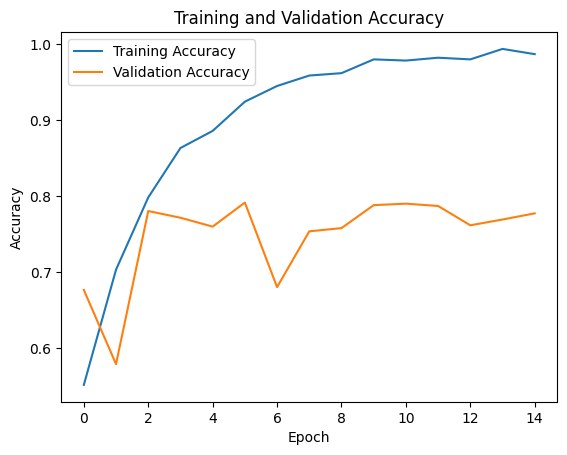

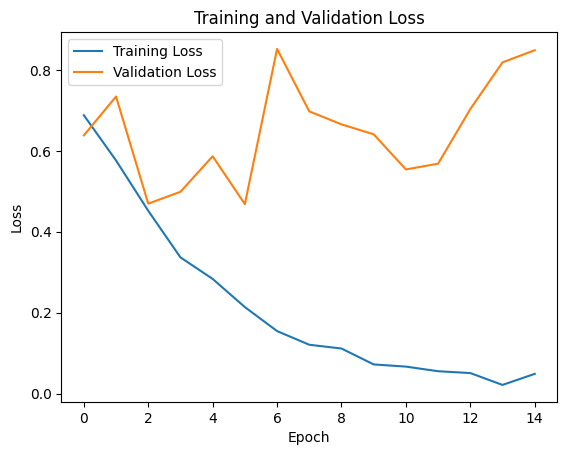

In [ ]:

import matplotlib.pyplot as plt

# Visualize the training and validation accuracy over epochs.
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualize the training and validation loss across epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



### Using the Embedded level to extract embedded words

Applying an Anchoring Level in Action


In [ ]:
em_layer = layers.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=256)

Anchor layer system developed from scratch

In [ ]:
in1 = keras.Input(shape=(None,), dtype="int64")
em1 = layers.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=256)(in1)
x = layers.Bidirectional(layers.LSTM(32))(em1)
x = layers.Dropout(0.5)(x)
output_layer1 = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(in1, output_layer1)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, None, 256)           │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          73,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoint_callbacks1 = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",
                                    save_best_only=True)
]

history1 = model.fit(vectorized_training_dataset, validation_data=vectorized_validation_dataset, epochs=15, callbacks=checkpoint_callbacks1)

model = keras.models.load_model("embeddings_bidir_gru.keras")


print(f"Test acc: {model.evaluate(int_test_dataset)[1]:.3f}")


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.5301 - loss: 0.6916 - val_accuracy: 0.6317 - val_loss: 0.6470
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.6764 - loss: 0.6121 - val_accuracy: 0.7391 - val_loss: 0.5567
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.7911 - loss: 0.4788 - val_accuracy: 0.7583 - val_loss: 0.5088
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.8514 - loss: 0.3763 - val_accuracy: 0.7268 - val_loss: 0.5881
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.8710 - loss: 0.3380 - val_accuracy: 0.7860 - val_loss: 0.5381
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - accuracy: 0.9099 - loss: 0.2652 - val_accuracy: 0.7362 - val_loss: 0.5754
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - accuracy: 0.9370 - loss: 0.1868 - val_accuracy: 0.7707 - val_loss: 0.5240
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.9533 - loss: 0.1488 - 

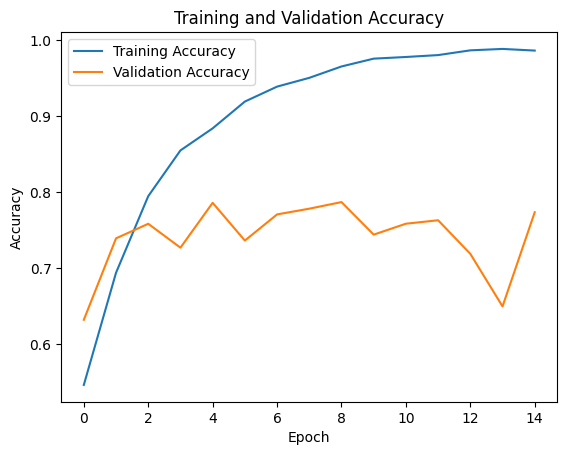

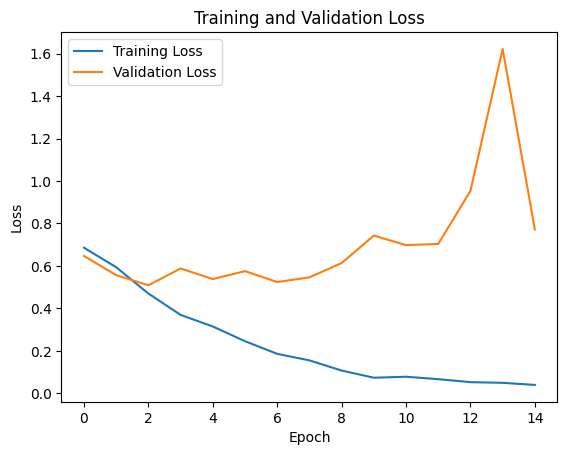

In [ ]:
# Plot the training and validation accuracy across epochs.
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualize the loss curves for both training and validation sets.
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Identifying and addressing blurring and filling

Implementing filtering at the Anchoring level


In [ ]:
in2 = keras.Input(shape=(None,), dtype="int64")
em2 = layers.Embedding(
    input_dim=MAX_VOCAB_SIZE, output_dim=256, mask_zero=True)(in2)
x = layers.Bidirectional(layers.LSTM(32))(em2)
x = layers.Dropout(0.5)(x)
output_layer2 = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(in2, output_layer2)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, None, 256)      │      2,560,000 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_2 (NotEqual)    │ (None, None)           │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 64)             │         73,984 │ embedding_3[0][0],     │
│ (Bidirectional)           │                        │                │ not_equal_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64)             │              0 │ bidirectional_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             65 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoint_callbacks2 = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
                                    save_best_only=True)
]
history2=model.fit(vectorized_training_dataset, validation_data= vectorized_validation_dataset, epochs=15, callbacks=checkpoint_callbacks2)


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.5356 - loss: 0.6907 - val_accuracy: 0.6658 - val_loss: 0.6519
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.6910 - loss: 0.5970 - val_accuracy: 0.7574 - val_loss: 0.4951
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.8118 - loss: 0.4291 - val_accuracy: 0.8017 - val_loss: 0.4357
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.8773 - loss: 0.3106 - val_accuracy: 0.7981 - val_loss: 0.4966
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.9102 - loss: 0.2389 - val_accuracy: 0.8079 - val_loss: 0.4523
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.9294 - loss: 0.1846 - val_accuracy: 0.7942 - val_loss: 0.4744
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.9552 - loss: 0.1319 - val_accuracy: 0.7958 - val_loss: 0.5144
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9682 - loss: 0.0930 - val

In [ ]:

model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model.evaluate(int_test_dataset)[1]:.3f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7883 - loss: 0.4483
Test acc: 0.795


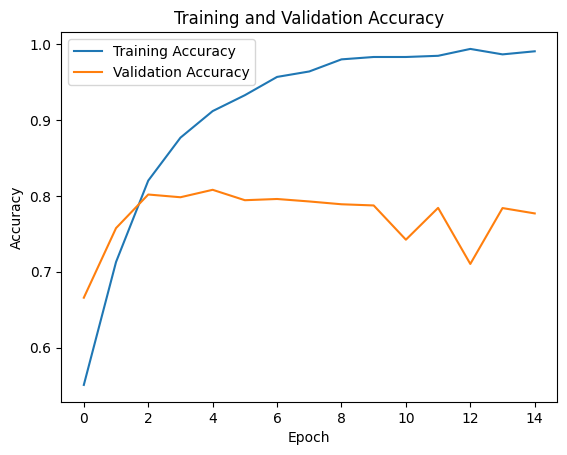

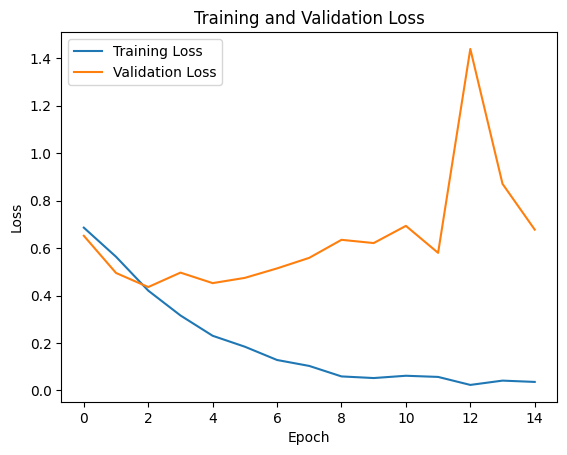

In [ ]:
# Plot training and validation accuracy
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualize training and validation loss over epochs
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Preprocessed word embeddings are utilized

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-04-03 23:36:39--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-03 23:36:39--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-03 23:36:39--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Interpreting the word-embeddings package for One

In [ ]:
import numpy as np
GLOVE_FILE_PATH = "glove.6B.100d.txt"

glove_embeddings = {}
with open(GLOVE_FILE_PATH) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        glove_embeddings[word] = coefs

print(f"Found {len(glove_embeddings)} word vectors.")

Found 400000 word vectors.


Configuring the matrix for the GloVe word embeddings from the website

In [ ]:
em_dim = 100

vocab = text_vectorization_layer.get_vocabulary()
word_to_index = dict(zip(vocab, range(len(vocab))))

embedding_matrix = np.zeros((MAX_VOCAB_SIZE, em_dim))
for word, i in word_to_index.items():
    if i < MAX_VOCAB_SIZE:
        em_vector = glove_embeddings.get(word)
    if em_vector is not None:
        embedding_matrix[i] = em_vector

In [ ]:
em_layer = layers.Embedding(
    MAX_VOCAB_SIZE,
    em_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

### Architecture with a trained embedded layer

In [ ]:
in4 = keras.Input(shape=(None,), dtype="int64")
em4 = em_layer(in4)
x = layers.Bidirectional(layers.LSTM(32))(em4)
x = layers.Dropout(0.5)(x)
output_layer4 = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(in4, output_layer4)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, None, 100)      │      1,000,000 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_4 (NotEqual)    │ (None, None)           │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 64)             │         34,048 │ embedding_4[0][0],     │
│ (Bidirectional)           │                        │                │ not_equal_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64)             │              0 │ bidirectional_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │             65 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,034,113 (3.94 MB)

 Trainable params: 34,113 (133.25 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [ ]:
checkpoint_callbacks4 = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]

history4=model.fit(vectorized_training_dataset, validation_data= vectorized_validation_dataset, epochs=15, callbacks=checkpoint_callbacks4)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test Accuracy: {model.evaluate(int_test_dataset)[1]:.3f}")

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - accuracy: 0.5275 - loss: 0.7039 - val_accuracy: 0.5992 - val_loss: 0.6633
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.6161 - loss: 0.6523 - val_accuracy: 0.6806 - val_loss: 0.6047
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - accuracy: 0.6800 - loss: 0.6035 - val_accuracy: 0.7414 - val_loss: 0.5464
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - accuracy: 0.7199 - loss: 0.5569 - val_accuracy: 0.7398 - val_loss: 0.5351
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.7332 - loss: 0.5369 - val_accuracy: 0.7382 - val_loss: 0.5439
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.7526 - loss: 0.5091 - val_accuracy: 0.7281 - val_loss: 0.5322
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.7811 - loss: 0.4906 - val_accuracy: 0.7771 - val_loss: 0.4751
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.7738 - loss: 0.4767 - v

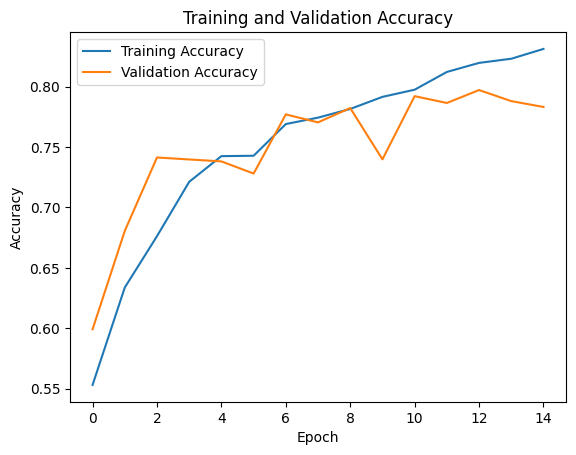

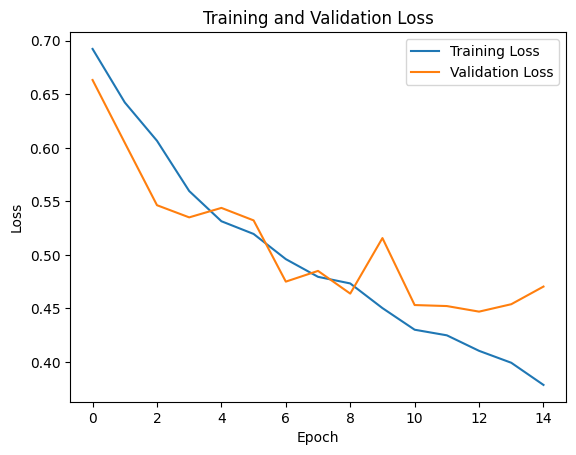

In [ ]:
# Visualize accuracy trends over training and validation sets
plt.plot(history4.history['accuracy'], label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualize training and validation loss across epochs
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Found 5000 files belonging to 2 classes.
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.5066 - loss: 0.6933 - val_accuracy: 0.5602 - val_loss: 0.6891
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.6123 - loss: 0.6715 - val_accuracy: 0.7117 - val_loss: 0.5926
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.7327 - loss: 0.5565 - val_accuracy: 0.7434 - val_loss: 0.5360
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - accuracy: 0.8238 - loss: 0.4355 - val_accuracy: 0.7725 - val_loss: 0.4832
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.8681 - loss: 0.3510 - val_accuracy: 0.7868 - val_loss: 0.4630
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - accuracy: 0.8848 - loss: 0.2866 - val_accuracy: 0.6991 - val_loss: 0.7506
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - accuracy: 0.9165 - loss: 0.2194 - val_accuracy: 0.7541 - val_loss: 0.6251
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/

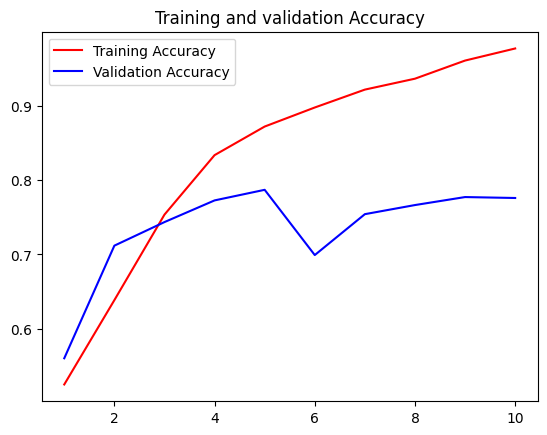

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.5199 - loss: 0.7061 - val_accuracy: 0.6029 - val_loss: 0.6649
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.6074 - loss: 0.6605 - val_accuracy: 0.7003 - val_loss: 0.5889
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.6736 - loss: 0.6063 - val_accuracy: 0.6909 - val_loss: 0.5842
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.7159 - loss: 0.5656 - val_accuracy: 0.7095 - val_loss: 0.5874
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.7011 - loss: 0.5693 - val_accuracy: 0.7414 - val_loss: 0.5327
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - accuracy: 0.7414 - loss: 0.5218 - val_accuracy: 0.7013 - val_loss: 0.5698
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.7613 - loss: 0.4862 - val_accuracy: 0.7672 - val_loss: 0.4856
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.7813 - loss: 0.4821 - v

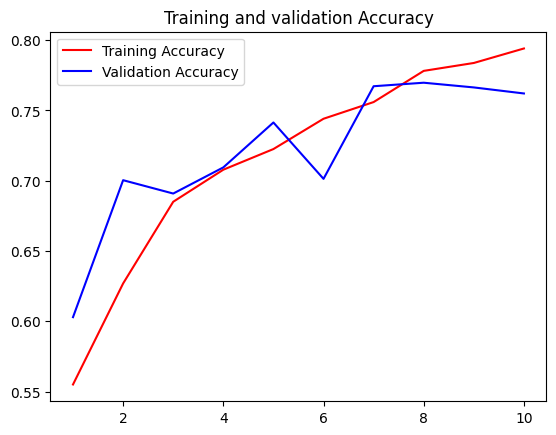

Training samples: 100
Embedding layer test accuracy: 0.776
Pretrained embeddings test accuracy: 0.762
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.5098 - loss: 0.6918 - val_accuracy: 0.6943 - val_loss: 0.6275
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.7162 - loss: 0.5902 - val_accuracy: 0.7138 - val_loss: 0.5768
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8119 - loss: 0.4519 - val_accuracy: 0.6635 - val_loss: 0.7636
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.8530 - loss: 0.3750 - val_accuracy: 0.8024 - val_loss: 0.4540
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.8833 - loss: 0.3010 - val_accuracy: 0.8159 - val_loss: 0.4798
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9114 - loss: 0.2329 - val_accuracy: 0.8012 - val_loss: 0.4933
Epoch 7/10
157/157 ━━━━━━━━

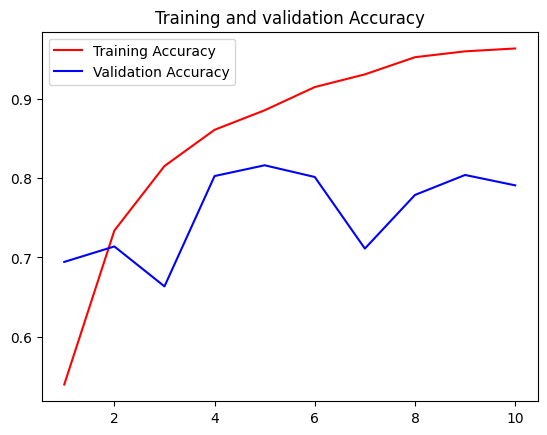

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.5327 - loss: 0.6965 - val_accuracy: 0.6673 - val_loss: 0.6129
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - accuracy: 0.6650 - loss: 0.6171 - val_accuracy: 0.7077 - val_loss: 0.5733
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - accuracy: 0.7001 - loss: 0.5679 - val_accuracy: 0.5533 - val_loss: 0.8014
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.7239 - loss: 0.5422 - val_accuracy: 0.7116 - val_loss: 0.5366
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.7521 - loss: 0.5165 - val_accuracy: 0.7684 - val_loss: 0.4819
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.7666 - loss: 0.4861 - val_accuracy: 0.7753 - val_loss: 0.4969
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.7903 - loss: 0.4502 - val_accuracy: 0.6664 - val_loss: 0.7486
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - accuracy: 0.7931 - loss: 0.4457 - va

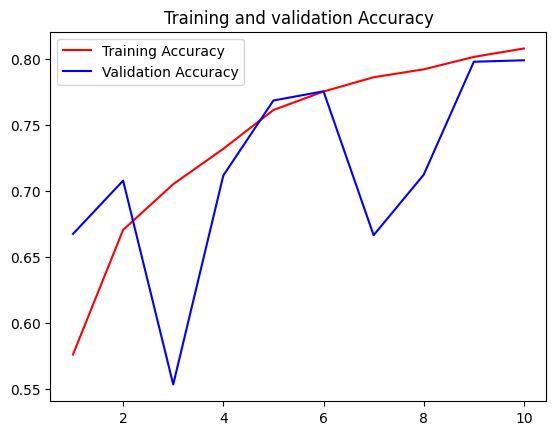

Training samples: 500
Embedding layer test accuracy: 0.788
Pretrained embeddings test accuracy: 0.792
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.5168 - loss: 0.6918 - val_accuracy: 0.6396 - val_loss: 0.6419
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.6971 - loss: 0.5976 - val_accuracy: 0.7671 - val_loss: 0.5008
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8097 - loss: 0.4511 - val_accuracy: 0.7883 - val_loss: 0.4747
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.8585 - loss: 0.3592 - val_accuracy: 0.8134 - val_loss: 0.4419
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.8926 - loss: 0.2972 - val_accuracy: 0.8034 - val_loss: 0.4437
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.9143 - loss: 0.2296 - val_accuracy: 0.8105 - val_loss: 0.4708
Epoch 7/10
157/157 ━━━━━━━━━

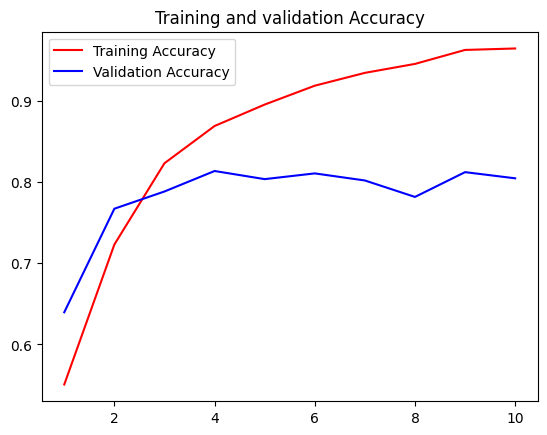

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.5283 - loss: 0.6972 - val_accuracy: 0.5756 - val_loss: 0.7068
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.6706 - loss: 0.6119 - val_accuracy: 0.7074 - val_loss: 0.5705
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.7259 - loss: 0.5649 - val_accuracy: 0.7047 - val_loss: 0.5645
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.7354 - loss: 0.5408 - val_accuracy: 0.7692 - val_loss: 0.4900
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.7668 - loss: 0.4948 - val_accuracy: 0.6703 - val_loss: 0.6405
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.7743 - loss: 0.4794 - val_accuracy: 0.7310 - val_loss: 0.5321
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.7856 - loss: 0.4578 - val_accuracy: 0.7700 - val_loss: 0.4740
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 103ms/step - accuracy: 0.7927 - loss: 0.4462 - val

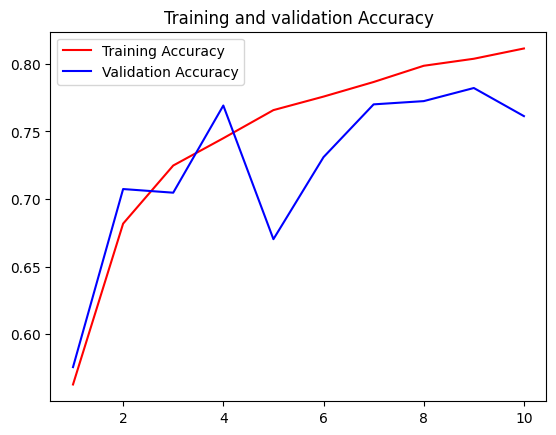

Training samples: 1000
Embedding layer test accuracy: 0.804
Pretrained embeddings test accuracy: 0.772
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.5169 - loss: 0.6914 - val_accuracy: 0.5971 - val_loss: 0.6555
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.7086 - loss: 0.5872 - val_accuracy: 0.7789 - val_loss: 0.4868
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.8038 - loss: 0.4504 - val_accuracy: 0.6905 - val_loss: 0.8965
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step - accuracy: 0.8580 - loss: 0.3574 - val_accuracy: 0.8120 - val_loss: 0.4215
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.8875 - loss: 0.2873 - val_accuracy: 0.7552 - val_loss: 0.7198
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.9100 - loss: 0.2446 - val_accuracy: 0.7378 - val_loss: 0.6056
Epoch 7/10
157/157 ━━━━━━━━━

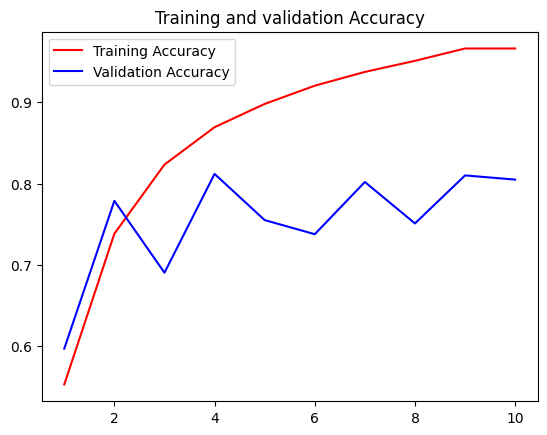

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.5465 - loss: 0.6957 - val_accuracy: 0.6721 - val_loss: 0.6127
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.6450 - loss: 0.6285 - val_accuracy: 0.6827 - val_loss: 0.6134
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.6946 - loss: 0.5847 - val_accuracy: 0.6977 - val_loss: 0.6120
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.7287 - loss: 0.5503 - val_accuracy: 0.7206 - val_loss: 0.5364
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.7460 - loss: 0.5192 - val_accuracy: 0.7623 - val_loss: 0.5138
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.7768 - loss: 0.4842 - val_accuracy: 0.7397 - val_loss: 0.5309
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.7901 - loss: 0.4535 - val_accuracy: 0.6647 - val_loss: 0.6351
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.7829 - loss: 0.4530 - va

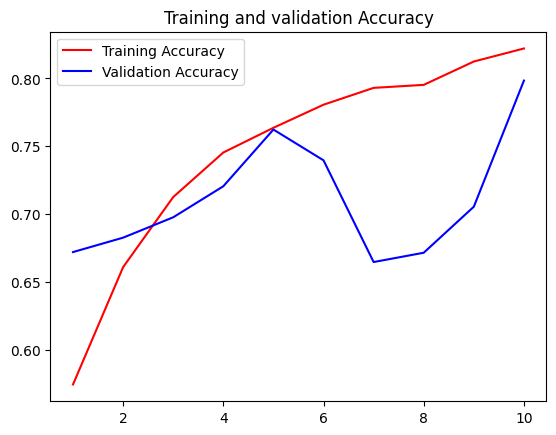

Training samples: 5000
Embedding layer test accuracy: 0.804
Pretrained embeddings test accuracy: 0.796
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.5304 - loss: 0.6893 - val_accuracy: 0.6594 - val_loss: 0.6231
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.7272 - loss: 0.5589 - val_accuracy: 0.8009 - val_loss: 0.4486
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8315 - loss: 0.4067 - val_accuracy: 0.8037 - val_loss: 0.4470
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.8778 - loss: 0.3195 - val_accuracy: 0.8138 - val_loss: 0.4252
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.8979 - loss: 0.2856 - val_accuracy: 0.7995 - val_loss: 0.4581
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step - accuracy: 0.9188 - loss: 0.2205 - val_accuracy: 0.8119 - val_loss: 0.4680
Epoch 7/10
157/157 ━━━━━━━━

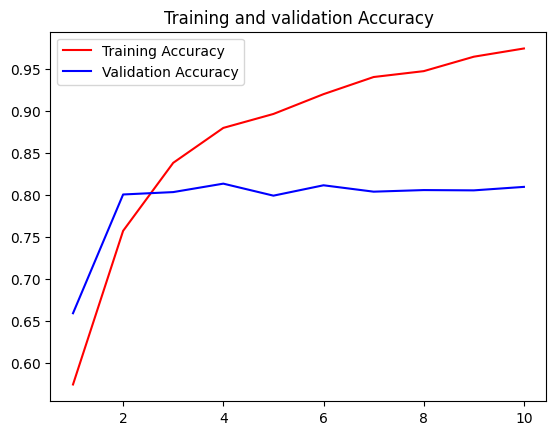

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.5324 - loss: 0.6957 - val_accuracy: 0.5622 - val_loss: 0.6970
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.6158 - loss: 0.6594 - val_accuracy: 0.6033 - val_loss: 0.6819
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.7011 - loss: 0.5857 - val_accuracy: 0.5953 - val_loss: 0.7690
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.7252 - loss: 0.5532 - val_accuracy: 0.7450 - val_loss: 0.5186
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.7519 - loss: 0.5225 - val_accuracy: 0.7607 - val_loss: 0.5040
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.7704 - loss: 0.4944 - val_accuracy: 0.7813 - val_loss: 0.4671
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.7879 - loss: 0.4630 - val_accuracy: 0.7811 - val_loss: 0.4722
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.7903 - loss: 0.4532 - va

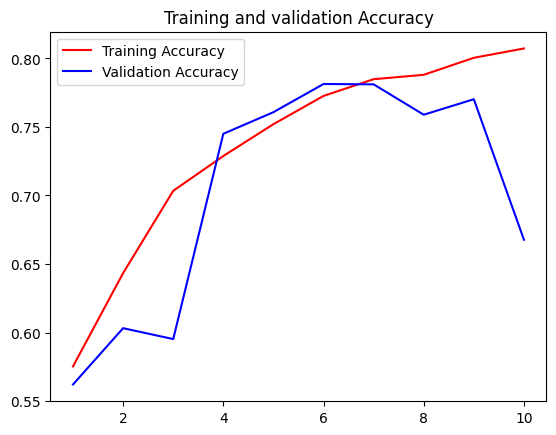

Training samples: 10000
Embedding layer test accuracy: 0.802
Pretrained embeddings test accuracy: 0.774
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.5314 - loss: 0.6897 - val_accuracy: 0.7147 - val_loss: 0.5897
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.7116 - loss: 0.5746 - val_accuracy: 0.7846 - val_loss: 0.4787
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.8095 - loss: 0.4498 - val_accuracy: 0.8065 - val_loss: 0.4291
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.8456 - loss: 0.3798 - val_accuracy: 0.7860 - val_loss: 0.5316
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.8922 - loss: 0.2910 - val_accuracy: 0.7708 - val_loss: 0.5505
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.9126 - loss: 0.2441 - val_accuracy: 0.8046 - val_loss: 0.4773
Epoch 7/10
157/157 ━━━━━━

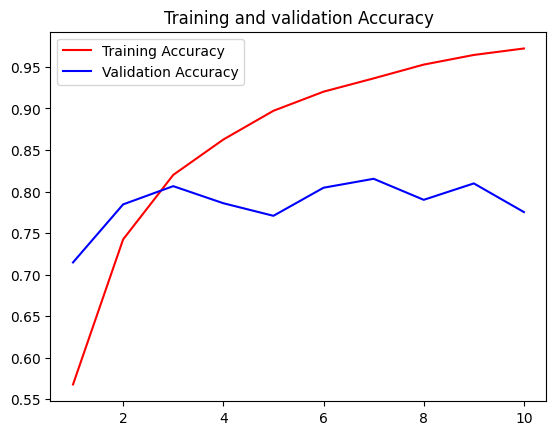

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - accuracy: 0.5426 - loss: 0.6938 - val_accuracy: 0.6202 - val_loss: 0.6549
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.6577 - loss: 0.6181 - val_accuracy: 0.5888 - val_loss: 0.7407
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.7118 - loss: 0.5718 - val_accuracy: 0.7519 - val_loss: 0.5168
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.7295 - loss: 0.5437 - val_accuracy: 0.7506 - val_loss: 0.5156
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.7513 - loss: 0.5195 - val_accuracy: 0.6446 - val_loss: 0.7826
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.7583 - loss: 0.5067 - val_accuracy: 0.7861 - val_loss: 0.4627
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.7698 - loss: 0.4868 - val_accuracy: 0.7728 - val_loss: 0.4824
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7831 - loss: 0.4568 - v

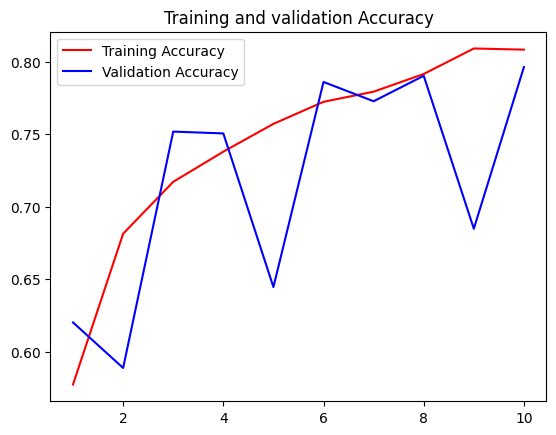

Training samples: 20000
Embedding layer test accuracy: 0.799
Pretrained embeddings test accuracy: 0.791
--------------------------------------------------


In [ ]:
train_sample_sizes = [100, 500, 1000, 5000, 10000, 20000]
for train_size in train_sample_sizes:
    training_dataset = keras.utils.text_dataset_from_directory(
        "aclImdb/train", batch_size=batch_size
    ).take(train_size)

    int_training_dataset = training_dataset.map(
        lambda x, y: (text_vectorization_layer(x), y),
        num_parallel_calls=4
    )
    int_validation_dataset = validation_dataset.map(
        lambda x, y: (text_vectorization_layer(x), y),
        num_parallel_calls=4
    )
    int_test_dataset = test_dataset.map(
        lambda x, y: (text_vectorization_layer(x), y),
        num_parallel_calls=4
    )

    # Train and assess the model incorporating a trainable embedding layer.
    embedding_layer = layers.Embedding(MAX_VOCAB_SIZE, em_dim)

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    callbacks = [
        keras.callbacks.ModelCheckpoint("embeddings_model.keras", save_best_only=True)
    ]
    history = model.fit(int_training_dataset, validation_data=int_validation_dataset, epochs=10, callbacks=callbacks)
    model = keras.models.load_model("embeddings_model.keras")
    embedding_layer_test_acc = model.evaluate(int_test_dataset)[1]

    loss = history.history["accuracy"]
    val_loss = history.history["val_accuracy"]
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, "r", label="Training Accuracy")
    plt.plot(epochs, val_loss, "b", label="Validation Accuracy")
    plt.title("Training and validation Accuracy")
    plt.legend()
    plt.show()

    # Train and evaluate the model utilizing pretrained word embeddings.
    embedding_layer = layers.Embedding(
        MAX_VOCAB_SIZE,
        em_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,
        mask_zero=True,
    )

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    callbacks = [
        keras.callbacks.ModelCheckpoint("pretrained_embeddings_model.keras", save_best_only=True)
    ]
    history = model.fit(int_training_dataset, validation_data=int_validation_dataset, epochs=10, callbacks=callbacks)
    model = keras.models.load_model("pretrained_embeddings_model.keras")
    pretrained_embeddings_test_acc = model.evaluate(int_test_dataset)[1]

    loss = history.history["accuracy"]
    val_loss = history.history["val_accuracy"]
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, "r", label="Training Accuracy")
    plt.plot(epochs, val_loss, "b", label="Validation Accuracy")
    plt.title("Training and validation Accuracy")
    plt.legend()
    plt.show()

    # Evaluate and compare model performance, and record the results.
    print(f"Training samples: {train_size}")
    print(f"Embedding layer test accuracy: {embedding_layer_test_acc:.3f}")
    print(f"Pretrained embeddings test accuracy: {pretrained_embeddings_test_acc:.3f}")
    print("-" * 50)


